# Montbrió–Pazó–Roxin (MPR) SDE — Simulation & Likelihood-Free Inference<br>
Minimal example using Numba-accelerated `MPR_sde` from `vbi`.<br>
Sections are short and documented so you can convert to a notebook easily.<br>
External APIs remain unchanged; only our helper functions are refactored.

<a href="https://colab.research.google.com/github/Ziaeemehr/vbi_paper/blob/main/docs/examples/mpr_sde_numba_cde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install VBI package in Google Colab (lightweight, CPU-only version)
print("Setting up VBI for Google Colab...")

# Skip C++ compilation for faster installation in Colab
%env SKIP_CPP=1

# Install the package
!pip install vbi

print("VBI package installed successfully! Ready to proceed.")

Setting up VBI for Google Colab...
env: SKIP_CPP=1
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v4, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
  Using cached vbi-0.3-py3-none-any.whl
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic/numpy-2.3.3+computecanada-cp311-cp311-linux_x86_64.whl (from vbi)
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic/scipy-1.16.2+computecanada-cp311-cp311-linux_x86_64.whl (from vbi)
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic/numba-0.62.1+computecanada-cp311-cp311-linux_x86_64.whl (from vbi)
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3/h5py-3.15.0+computecanada-cp311-cp311-linux_x86_64.whl (from vbi)

#### Imports & Global Config

In [2]:
import os
import warnings
from copy import deepcopy
import multiprocessing as mp
from multiprocessing import Pool

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
import vbi
from vbi.models.numba.mpr import MPR_sde

/home/mgolmoha/scratch/VBI/vbi-py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
warnings.simplefilter("ignore")
print(f"vbi version: {vbi.__version__}")

vbi version: 0.3


In [9]:
SEED = 42
np.random.seed(SEED)

In [10]:
LABELSIZE = 10
plt.rcParams["axes.labelsize"] = LABELSIZE
plt.rcParams["xtick.labelsize"] = LABELSIZE
plt.rcParams["ytick.labelsize"] = LABELSIZE

In [8]:
OUT_DIR = "output/mpr_sde_numba_cde_/"
os.makedirs(OUT_DIR, exist_ok=True)

If False: (re)generate data; if True: load from disk when available.

In [11]:
LOAD_DATA = True

#### Prior & Training Data Generation

In [20]:
data = np.load("sub-0001_theta_X.npz")  # replace with your file if different
theta = data["theta"]                 # shape: [2000, n_params]
X = data["X"]                         # shape: [2000, n_features]
theta = theta[:, None]  # shape becomes (2000, 1)

In [21]:
print (theta)
print (X)

[[1.90952476]
 [1.89      ]
 [1.92254126]
 ...
 [2.16952942]
 [2.10135548]
 [2.16969213]]
[[3.41994394e-04 2.68820251e-02 9.76459187e+00]
 [4.18792691e-04 3.78492909e-02 3.86040337e+00]
 [2.35278128e-04 2.45589925e-02 3.36536076e+00]
 ...
 [3.49302385e-03 1.66666338e-01 3.57881251e+00]
 [1.01566938e-03 3.52580633e-01 2.30199165e+00]
 [3.13026976e-03 3.63449960e-01 3.64839951e+00]]


#### Train Density Estimator (MAF) & Posterior Summary

In [22]:
from vbi.utils import posterior_shrinkage_numpy, posterior_zscore_numpy
from vbi.cde import MAFEstimator
import autograd.numpy as anp

In [23]:
rng = anp.random.RandomState(SEED)
maf = MAFEstimator(n_flows=4, hidden_units=64)
maf.train(theta.astype(np.float32), X.astype(np.float32), n_iter=1000, learning_rate=2e-4)

Inferred dimensions: param_dim=1, feature_dim=3


Training: 100%|██████████| 1000/1000 [00:09<00:00, 105.40it/s, patience=0/20, train=0.5102, val=0.5728]


In [59]:
theta_true=1.9981996895
x_obs = np.array([[0.00057955, 0.08636922, 4.60960942]], dtype=np.float32)

print(x_obs.shape)  # (1, 2)

(1, 3)


In [60]:
samples = maf.sample(x_obs, n_samples=5000, rng=rng)[0]
shrinkage = posterior_shrinkage_numpy(theta, samples)
zscore = posterior_zscore_numpy(2.099, samples)

In [61]:
print("True parameters:     ", theta_true)
print("MAF mean estimate:   ", np.mean(samples, axis=0))
print("Posterior shrinkage: ", np.array2string(shrinkage, precision=3, separator=", "))
print("Posterior z-score:   ", np.array2string(zscore, precision=3, separator=", "))

True parameters:      1.9981996895
MAF mean estimate:    [2.0089676]
Posterior shrinkage:  [0.803]
Posterior z-score:    [2.157]


In [62]:
np.savez(OUT_DIR + "samples.npz", samples=samples, xo=x_obs, theta_true= theta_true)

#### Feature–Parameter Scatter (Quick Diagnostic)

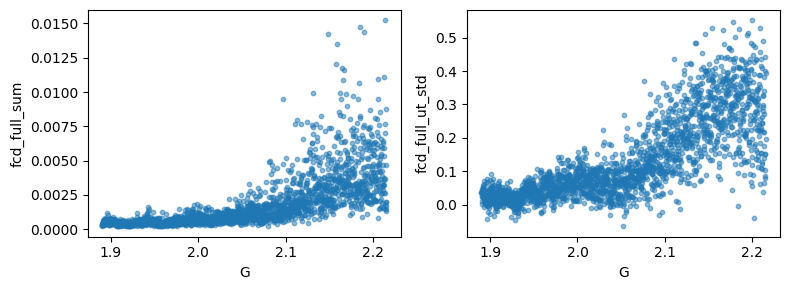

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].scatter(theta, X[:, 0], s=10, alpha=0.5)
ax[0].set_xlabel("G")
ax[0].set_ylabel("fcd_full_sum")
ax[1].scatter(theta, X[:, 1], s=10, alpha=0.5)
ax[1].set_xlabel("G")
ax[1].set_ylabel("fcd_full_ut_std")
plt.tight_layout()

#### FC / FCD Visualization for Observation

In [27]:
from vbi.feature_extraction.features_utils import get_fc, get_fcd
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [111]:
obs = np.load(OUT_DIR + "observation.npz")
bold_d = obs["bold_d"]   # (T, N)
bold_t = obs["bold_t"]   # (T,)

In [112]:
FC = get_fc(bold_d.T)["full"]
FCD = get_fcd(bold_d.T, win_len=25)["full"]

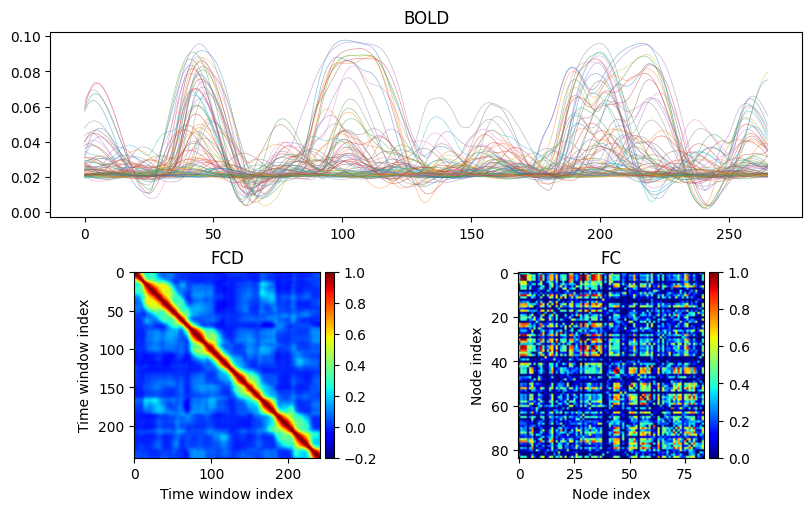

In [113]:
mosaic = """
AA
BC
"""
fig = plt.figure(constrained_layout=True, figsize=(8, 5))
axd = fig.subplot_mosaic(mosaic)
axd["A"].plot(bold_d, lw=0.5, alpha=0.5)
im0 = axd["B"].imshow(FCD, cmap="jet", vmin=-0.2, vmax=1)
im1 = axd["C"].imshow(FC,  cmap="jet", vmin=0,    vmax=1)
for key, im in [("B", im0), ("C", im1)]:
    div = make_axes_locatable(axd[key])
    cax = div.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
axd["A"].set_title("BOLD")
axd["B"].set_title("FCD")
axd["B"].set_xlabel("Time window index")
axd["B"].set_ylabel("Time window index")
axd["C"].set_title("FC")
axd["C"].set_xlabel("Node index")
axd["C"].set_ylabel("Node index")
plt.show()

#### Posterior Plot (Pairplot)

In [63]:
from vbi.plot import pairplot_numpy
prior_min = [1.89]
prior_max = [2.21525]

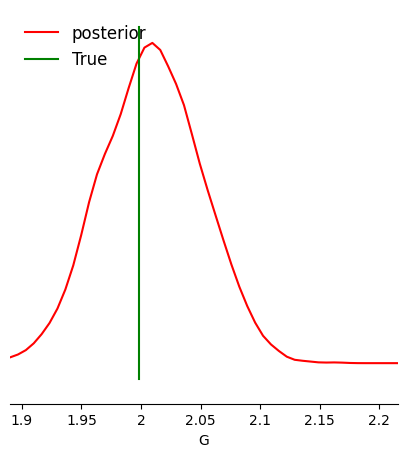

In [64]:
limits = [[lo, hi] for lo, hi in zip(prior_min, prior_max)]
fig, ax = pairplot_numpy(
    samples,
    limits=limits,
    figsize=(5, 5),
    points=np.array([theta_true]).reshape(1, -1),
    labels=["G"],
    offdiag="kde",
    diag="kde",
    fig_kwargs=dict(points_offdiag=dict(marker="*", markersize=10), points_colors=["g"]),
    diag_kwargs={"mpl_kwargs": {"color": "r"}},
)
plt.legend(["posterior", "True"], loc="upper left", fontsize=12, frameon=False)
fig.savefig(OUT_DIR + "/G.png", dpi=150)